<a href="https://colab.research.google.com/github/FanchonSora/AI-Project-Course/blob/main/Medical_prescription_to_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. C√†i ƒë·∫∑t c√°c th∆∞ vi·ªán c·∫ßn thi·∫øt v√† Tesseract OCR
!sudo apt-get install tesseract-ocr -qq
!pip install opencv-python Pillow pytesseract pandas -qq
!pip install torch torchvision transformers easyocr sentence-transformers faiss-cpu -q
!sudo apt-get install tesseract-ocr -qq
!pip install easyocr pytesseract opencv-python pillow transformers sentence-transformers faiss-cpu

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../t

In [3]:
!pip show easyocr opencv-python PIL


Name: easyocr
Version: 1.7.2
Summary: End-to-End Multi-Lingual Optical Character Recognition (OCR) Solution
Home-page: https://github.com/jaidedai/easyocr
Author: Rakpong Kittinaradorn
Author-email: r.kittinaradorn@gmail.com
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: ninja, numpy, opencv-python-headless, Pillow, pyclipper, python-bidi, PyYAML, scikit-image, scipy, Shapely, torch, torchvision
Required-by: 
---
Name: opencv-python
Version: 4.11.0.86
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy
Required-by: dopamine_rl, imgaug


In [5]:
# 2. Mount Google Drive ch·ª©a d·ªØ li·ªáu
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 3. Import c√°c th∆∞ vi·ªán
import os
import cv2
import pytesseract
import easyocr
import pandas as pd
from PIL import Image, ImageDraw
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import torch

In [7]:
# 4. Kh·ªüi t·∫°o c√°c m√¥-ƒëun AI
# --------------------------------------------------------
# a) Kh·ªüi t·∫°o EasyOCR cho ti·∫øng Anh.
#    N·∫øu b·∫°n mu·ªën nh·∫≠n di·ªán ng√¥n ng·ªØ kh√°c (VD: ti·∫øng Vi·ªát),
#    c√≥ th·ªÉ th√™m m√£ ng√¥n ng·ªØ t∆∞∆°ng ·ª©ng: ['en', 'vi']
reader = easyocr.Reader(['en'])

# b) Kh·ªüi t·∫°o pipeline cho Named Entity Recognition (NER)
#    S·ª≠ d·ª•ng model "dslim/bert-base-NER" ƒë√£ ƒë∆∞·ª£c fine-tune
ner_pipeline = pipeline(
    "ner",
    model="dslim/bert-base-NER",
    aggregation_strategy="simple"
)

# c) Kh·ªüi t·∫°o m√¥ h√¨nh SentenceTransformer
#    ƒë·ªÉ t·∫°o embedding vector cho t√™n thu·ªëc
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Progress: |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100.0% Complete

Progress: |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100.0% Complete

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# 4. ƒê·ªãnh nghƒ©a ƒë∆∞·ªùng d·∫´n t·ªõi c√°c th∆∞ m·ª•c v√† file d·ªØ li·ªáu
# Th∆∞ m·ª•c ch·ª©a ·∫£nh ƒë∆°n thu·ªëc
# Th∆∞ m·ª•c l∆∞u c√°c file OCR text t∆∞∆°ng ·ª©ng v·ªõi ·∫£nh ƒë∆°n thu·ªëc
# File CSV ch·ª©a metadata c·ªßa DrugBank (gi·∫£ s·ª≠ file c√≥ c·ªôt: drug_id, drug_name, description, [drug_image_path])
# ƒê·ªãnh nghƒ©a ƒë∆∞·ªùng d·∫´n t·ªõi th∆∞ m·ª•c ch·ª©a ·∫£nh c·ªßa thu·ªëc (drug_images)
# --------------------------------------------------------
prescription_images_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_images'
prescription_texts_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_texts'
drugbank_metadata_path = '/content/drive/MyDrive/AI_Project/dataset/drugbank_metadata.csv'
drug_images_folder = '/content/drive/MyDrive/AI_Project/dataset/drug_images'

In [9]:
def ocr_image(image_path):
    """
    S·ª≠ d·ª•ng EasyOCR ƒë·ªÉ nh·∫≠n di·ªán ch·ªØ trong ·∫£nh ƒë∆°n thu·ªëc.
    ƒê·∫ßu ti√™n m·ªü ·∫£nh b·∫±ng Pillow (PIL), chuy·ªÉn th√†nh numpy array r·ªìi g·ªçi EasyOCR.
    """
    from PIL import Image
    import numpy as np
    try:
        # M·ªü ·∫£nh v√† chuy·ªÉn ƒë·ªïi v·ªÅ RGB
        img_pil = Image.open(image_path).convert('RGB')
        # Chuy·ªÉn sang numpy array
        img_np = np.array(img_pil)
    except Exception as e:
        print("L·ªói khi m·ªü ·∫£nh v·ªõi PIL:", e)
        return ""

    # G·ªçi EasyOCR v·ªõi numpy array
    result = reader.readtext(img_np, detail=0)
    return " ".join(result)

In [10]:
def extract_drug_names(text):
    """
    S·ª≠ d·ª•ng pipeline NER (Named Entity Recognition) ƒë·ªÉ t√¨m
    c√°c th·ª±c th·ªÉ c√≥ nh√£n MISC (th∆∞·ªùng l√† t√™n ri√™ng,
    c√≥ th·ªÉ bao g·ªìm t√™n thu·ªëc) trong vƒÉn b·∫£n OCR.
    """
    entities = ner_pipeline(text)
    # L·ªçc ra nh·ªØng entity c√≥ label = 'MISC'
    drug_names = [entity['word'] for entity in entities if entity['entity_group'] == 'MISC']
    return drug_names

In [11]:
def search_drug_info(drug_name, drugbank_df, index, drug_embeddings):
    """
    T√¨m ki·∫øm thu·ªëc g·∫ßn ƒë√∫ng nh·∫•t trong DrugBank s·ª≠ d·ª•ng FAISS & Sentence Transformers.

    - drug_name: T√™n thu·ªëc t√¨m ki·∫øm (chu·ªói).
    - drugbank_df: DataFrame ch·ª©a metadata thu·ªëc (m√£, m√¥ t·∫£, v.v.).
    - index: FAISS Index ƒë√£ ƒë∆∞·ª£c x√¢y d·ª±ng.
    - drug_embeddings: M·∫£ng embeddings c·ªßa c·ªôt 'drug_name' trong drugbank_df.
    """
    # T·∫°o embedding cho t·ª´ kh√≥a t√¨m ki·∫øm
    query_embedding = sbert_model.encode(drug_name, convert_to_tensor=True).cpu().numpy()

    # T√¨m trong FAISS Index (top 1 k·∫øt qu·∫£)
    D, I = index.search(query_embedding.reshape(1, -1), 1)

    best_match_idx = I[0][0] if I[0][0] != -1 else None
    if best_match_idx is not None:
        return drugbank_df.iloc[best_match_idx]
    else:
        return None

In [12]:
# ƒê·ªçc file CSV ch·ª©a metadata thu·ªëc
drugbank_df = pd.read_csv(drugbank_metadata_path, encoding='cp1252')

In [13]:
# 7. X√¢y d·ª±ng FAISS index cho c·ªôt 'drug_name'
# T·∫°o embeddings cho t·∫•t c·∫£ t√™n thu·ªëc trong DataFrame
drug_embeddings = sbert_model.encode(drugbank_df['drug_name'].tolist(), convert_to_tensor=True).cpu().numpy()

# Kh·ªüi t·∫°o FAISS Index (s·ª≠ d·ª•ng L2 distance)
d = drug_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(drug_embeddings)

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 1.jpg
üìÑ K·∫øt qu·∫£ OCR:
Dr B; Who Farmstrcct 12 Kirkvillc tel, 3876 uate Lav 1994 ttriw 0.12 m% theoh ~ M0,7 44 hlt Lm Ms/Mr Pehuiof 30 address; 7v Yer+ Agc:
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 10.jpg
üìÑ K·∫øt qu·∫£ OCR:
Dr; MRCP (Uk) FrCA Ietuese Corsultant '{Oanto! CCT (Gasto) Livat Ttanuplart #euems"b Apollo [GAstRoenteroloGy No: 46200 Gastroenterologisl] and Wransplanl Hepaloloqist 040 2360 77 / Fot Extn 4005i14 Emaappoontments CJi Dem0005/0 A 6 AMt : 7102778809 aocpolav@gmail com yle/u To So Eve e IT MAY ConCeRn Thu U Jnlonm ~kat Mr- CK . SAmuel 6lyr | Malz Uu ccuuntly  admuttaf urdu Cau wiJh  Tp.No: 36+s88 y He 1 (usuly  Wrdiqeiy talii w CCU swesaSspsu tr dh Mobs Lui okstex? sNh Axpiraben   pruumonia )  Y6 fuku  needs  lerpilal alout & -l0 768 lorblut TF Jo 6 and Kurdly do -ba hnee dkul &n kprm Fuuki; Yau DE NAVEEN POLAVABAPU RCP Ln) WRCp Eio) VacP C

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


üìÑ K·∫øt qu·∫£ OCR:
DR; R; CombB t399 Zo Eih"fifzo 'Hj3 (stta+ ~rxx dyooek qp] Cszuk_@utak Emul 1Z3 77 i icott Dou Or eaupl 5322 734 1s 3k  12
üîç T√™n thu·ªëc nh·∫≠n di·ªán: ['Dou']
‚úÖ **Th√¥ng tin thu·ªëc ƒë∆∞·ª£c tr√≠ch xu·∫•t:**
üîπ **T√™n:** Dorzolamidum
üíä **M√¥ t·∫£:** "B?nh glaucoma (t?ng nh?n ¬†p) ?? gi?m ¬†p l?c trong m?t"
üîó **M√£ DrugBank:** DB005
üñºÔ∏è  ·∫¢nh thu·ªëc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


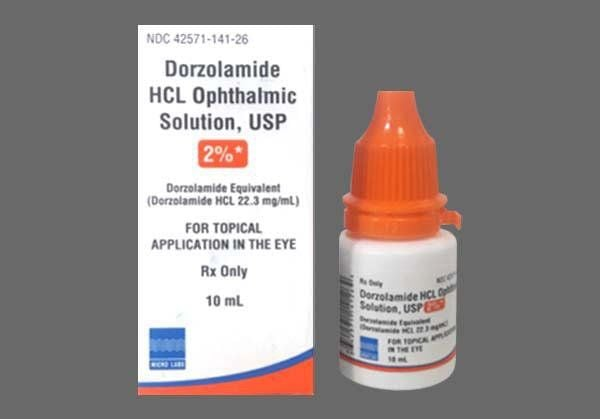

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 107.jpg
üìÑ K·∫øt qu·∫£ OCR:
R 78740 3 , > & es 6wdecec af Suc L 1 E: &5 4r40 ~l Jx Uea Jau ~ as 8 < - 3 1 n E HARRIMAN & FOSTER, dueb Registered Pharmacists, ~ceea dut Os WAITINSVILLE, MA8S. No. 424 {ocou M: D 03 Tr ! ~is Auxti. Ka;
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 116.jpg
üìÑ K·∫øt qu·∫£ OCR:
KAMBNENI R T A [ nGmad Ka Udcu 46|~ L odnu td u dhatrut ck ENt Will 2021/4013 IJe 6s Co Iu (ss ep baranoa  Giu "Lotrl t He u8h (U Gfosomal Glscuc R bieclon < Lox weele 4 nleo Yec k n Dr N.APOORVA REDDY Munir Re; Na 100275 Keid End Nect Oncoiutgeon (Rcs,Uki Contutznt ENT Hezd = Ne:' Sunjery raminen] Hosp (als LeNagaiHyc-68 Ozzderabad - 500068,TS (INDIA) 0-mail; Kamineni@kapiner?0r99879998324022272_ Ka kaminenihospilals com A 0 $ Ratent Lumo ^ menr{ Amk head kudk (abis _ B Nagar 24022277 24022222 5
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o

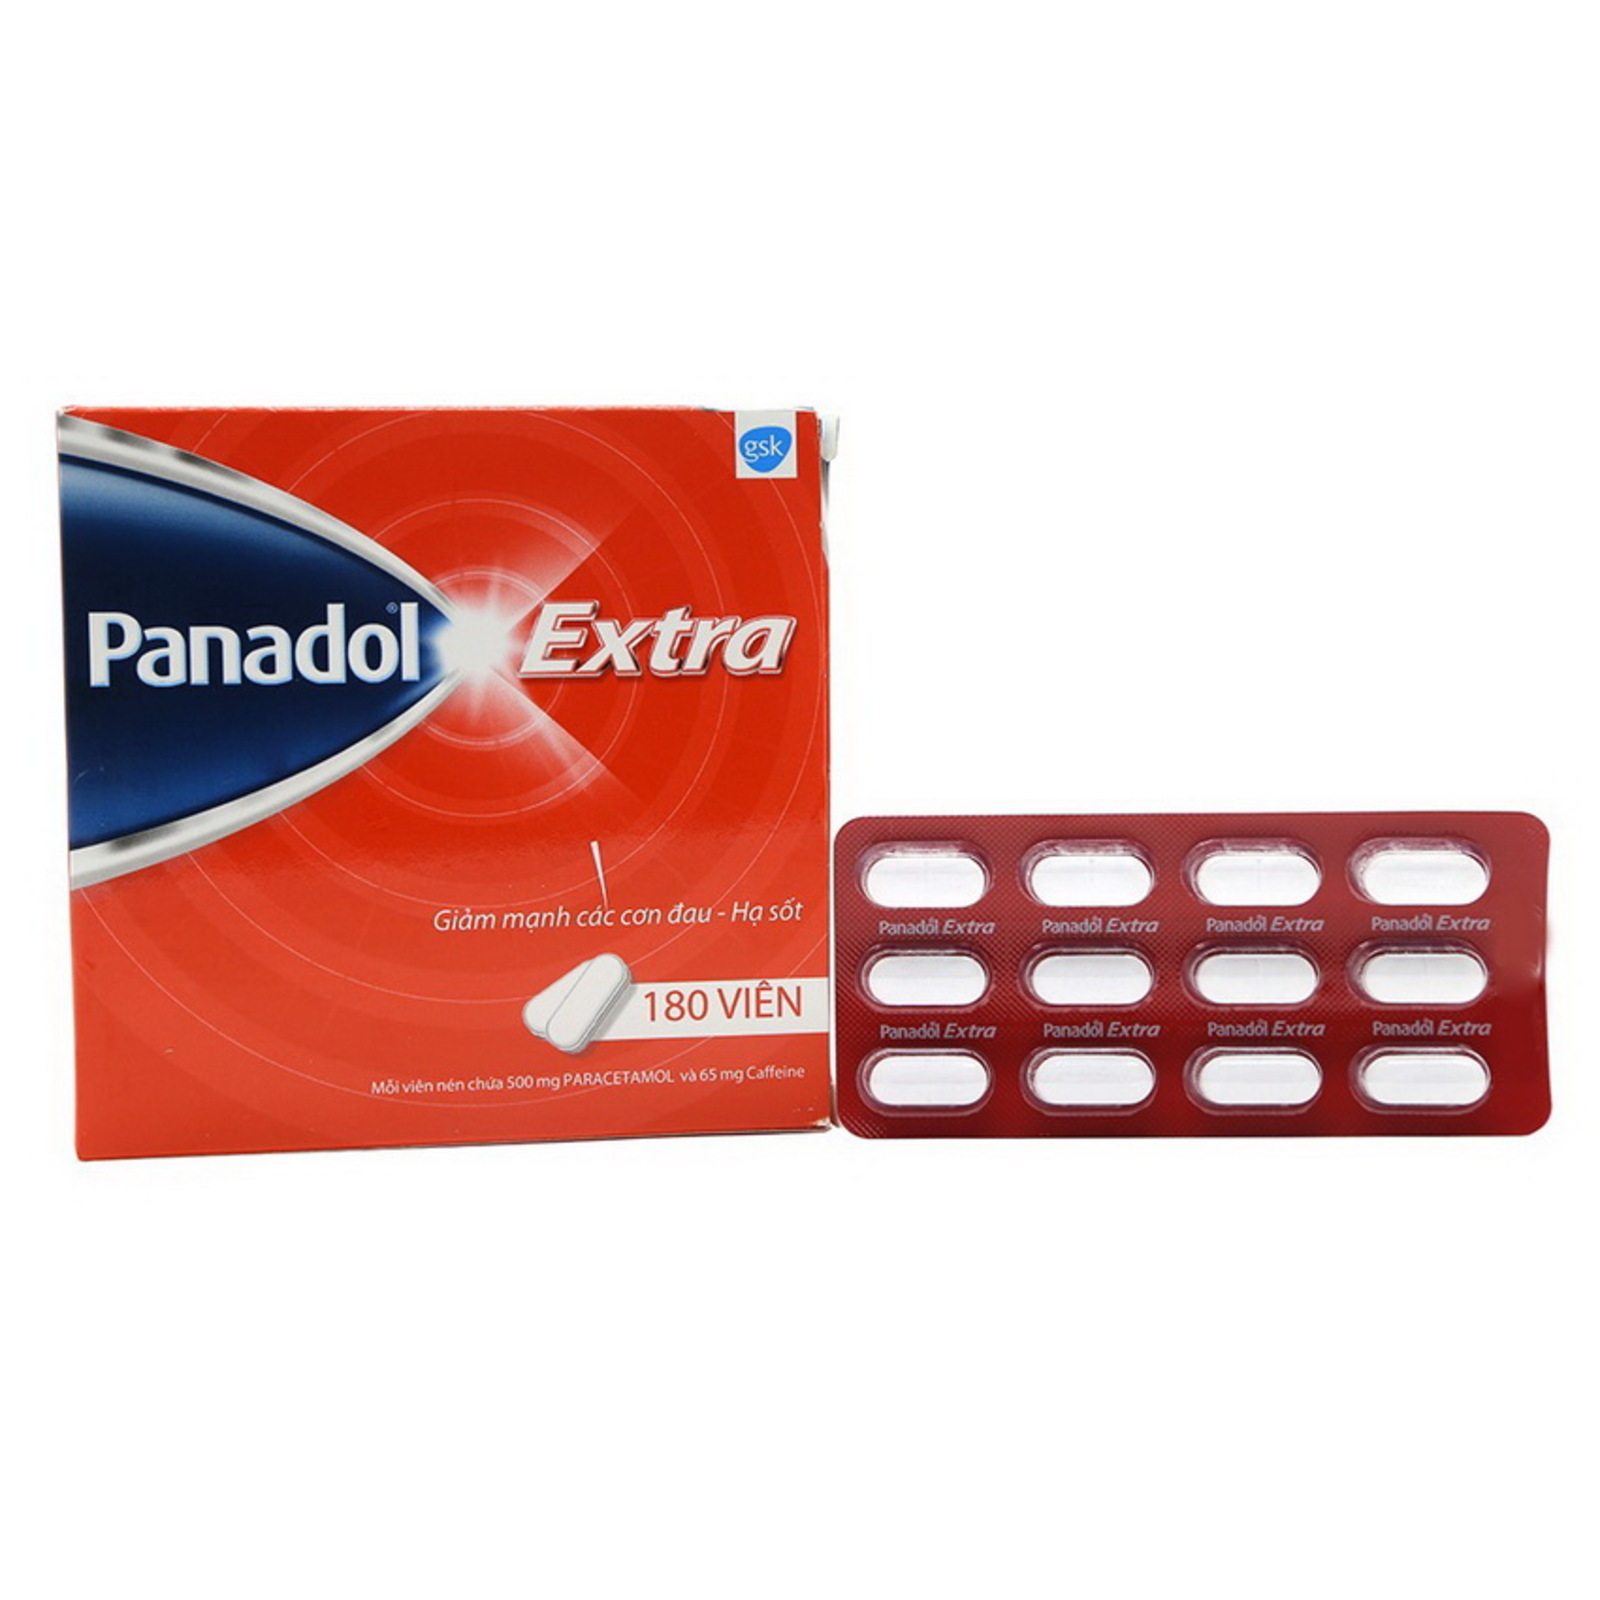

üîπ **T√™n:** Ibuprofen
üíä **M√¥ t·∫£:** "Thu?c gi?m ?au kh¬†ng viÀÜm"
üîó **M√£ DrugBank:** DB003
üñºÔ∏è  ·∫¢nh thu·ªëc: /content/drive/MyDrive/AI_Project/dataset/drug_images/ibuprofen.jpg


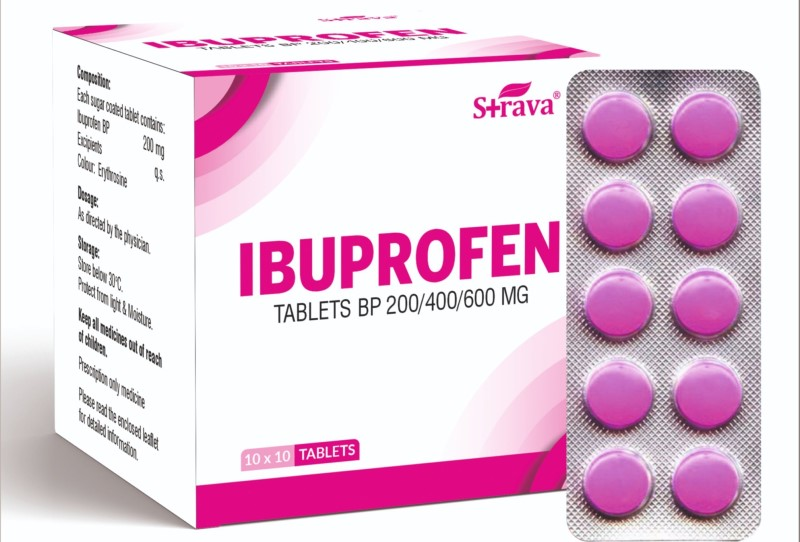

üîπ **T√™n:** Dorzolamidum
üíä **M√¥ t·∫£:** "B?nh glaucoma (t?ng nh?n ¬†p) ?? gi?m ¬†p l?c trong m?t"
üîó **M√£ DrugBank:** DB005
üñºÔ∏è  ·∫¢nh thu·ªëc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


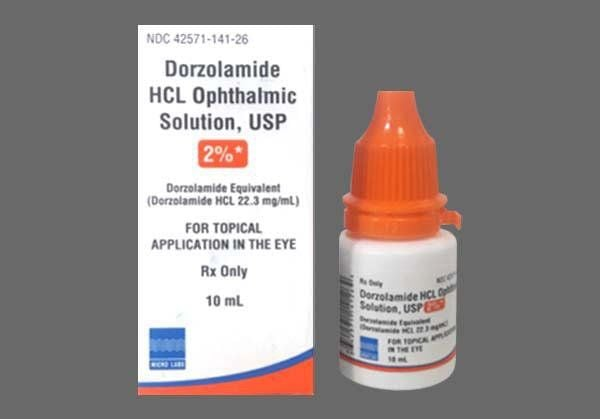

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 38.jpg
üìÑ K·∫øt qu·∫£ OCR:
NETAJI SUBHAS CHANDRA BOSE CANCER HOSPITAL (A Unit of Himadri Memotial Cancer Welfare Trust) NCRI Flaccatonto J08 | Nayabad,Kolkata 700 024 , India Desk (033) 7122J000 Mob 98742[0603 9874210067 Email inloonsch in , admintoinacti in, Wcb Wv ncIllin Doctor Prescription Paticnt Shila Dasgupta Doctor Name Dr,Soumcn Das MRNo a (Surgical Oncolosy Departinem) NCkI/34795 Appointmcnt 16-(14-2022 Sct Age 57 HeightAcight BP' / Fulse / (agen 1| svnptoms Clinical Examination Ilk luf WJM 2xu (e Ros Dragnosis T5Nj lr' 6 UCG : Ro BARAD 4 Uso Investigation Suggested PNAC Owikave LkCg Medicine Prescribed @mbrdus Cove Ps ' bxew 2 , PET CT Jcan TDY 60HA4 3 , Ruv Nert Follow up Date IX FBS Dr: Sounen D)a; No: 62701 MS FACS USAAMRCS(Edin) FRC S(Glasg} Chiel Consul 4nt Hresu Bowel MPFC Senis CANCER CARE AT AFFORDABLE COST Help Name Dale Mnstory kisr_ Cxeut buclA Duply Regn
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc 

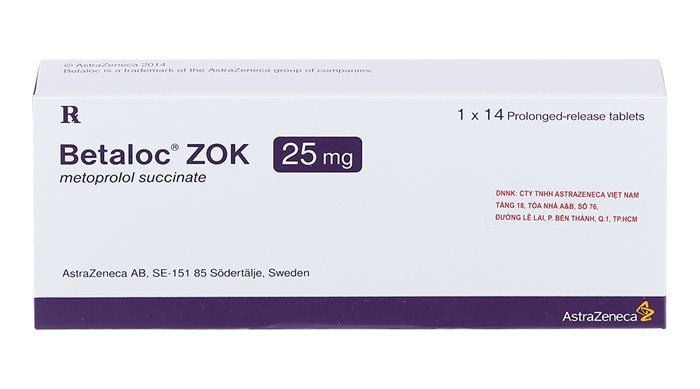

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 40.jpg
üìÑ K·∫øt qu·∫£ OCR:
Ugiiaki Kishan iukugu MD DNE (Int; 'Aedicing ‚Ç¨MC Vellore} YASHODA Consultant Physicen & Dibebolorix HOSPITALS No; 79602 Mobile; 770293264 Email drharikishangmall cot 3 | 8124 RAama clawdn (lo 60 L Cuiculy Ly (ay" Au( htoZceicn) A‚Ç¨ ( ( Cofom Anq(fom ‚Ç¨ S 0 {A6 } 3ou ~( (u ( & G40 ooJ (X7joy Dr: HARI KISHAN BOORUGU CONSULTANT PHYSICIRADNB Regd No; 79692 MASHODA HOSPITALS Somajiguda, Hyderabad-500 082 TALS; SOMAJIGUDA For EMERGENCYIQUERIES FOR APPOINTMENTS Sorajiguda; Hyderabad; Telangana 500 082 040 6723 2321(24 HRS) 040 4567 4567 (24 HrS athodamalcom wyashodahospilals com Rege Ostofo"
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 37.jpg
üìÑ K·∫øt qu·∫£ OCR:
Columbie 36 DR. W. P BAKER Physician and Surreon Office and Raidence, Kcefe Building Hilknan City . Scattle R rh O Daen For ~lit @ano&i 6~s. 227 Cozo @hevwo! 20 X V ! Fn e/& ~o&61 Xu 2

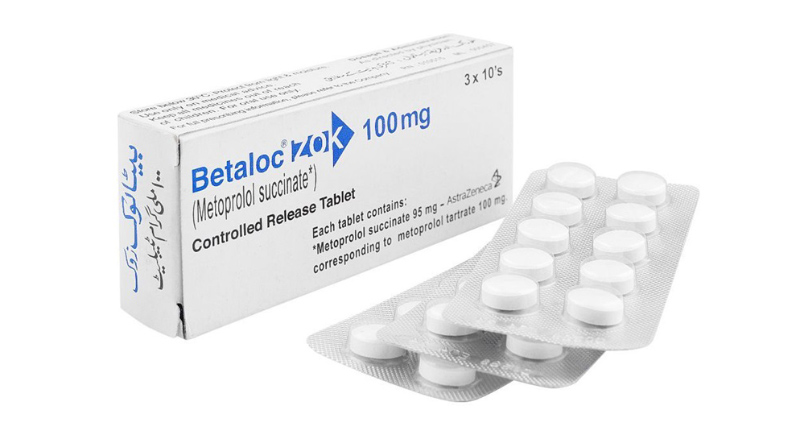

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 76.jpg
üìÑ K·∫øt qu·∫£ OCR:
MletLxo_ 1om M luul
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 83.jpg
üìÑ K·∫øt qu·∫£ OCR:
Date: Li4o_2Oto Aptus Medical Arts WE Hansen 123 Homestead PL Suite 2 1 Searchlight; NV 89046 Name: Iyeeteive (MJF Age: 51 Address: MilnLmi_RL Wt: L R Losnian 50 Ta6s , Dispense #30 Sig: T(ke on6 4 daily in The | koe Wood ueessevee conzeo‚Ç¨ Refill (ix times Signature 'WE_Hansen_Ip Generic Substitution 0K DEA #: I~ 46kg milliglam motih 'momnin
üîç T√™n thu·ªëc nh·∫≠n di·ªán: []
‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 88.jpg
üìÑ K·∫øt qu·∫£ OCR:
RADIO LSEA Confirming USA our QSO of:_ 13 20_ AT 214 UTC Mode 334 0 ON_ I i> MHz RST_ S HAM ALOHAe AxCvR OTHER 722 www.arrlorg OUTPUT 1zZ WATTS ANT 1 To: LA UP MtRS: CIS4 VE/5164 REMARKS: 710 a_ ^ Zu_ LsLUze 31L~ 2 2 22331 4s RS Fzc nz_ Zan 71z _ CL Tr 0 L4eh_z-72

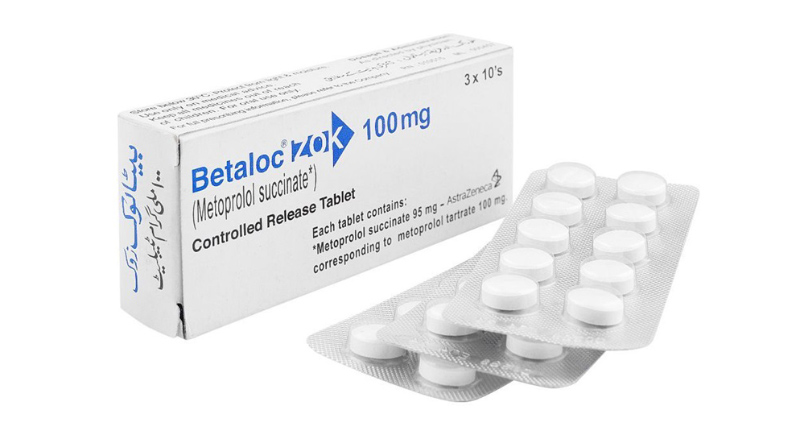

üîπ **T√™n:** Dorzolamidum
üíä **M√¥ t·∫£:** "B?nh glaucoma (t?ng nh?n ¬†p) ?? gi?m ¬†p l?c trong m?t"
üîó **M√£ DrugBank:** DB005
üñºÔ∏è  ·∫¢nh thu·ªëc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


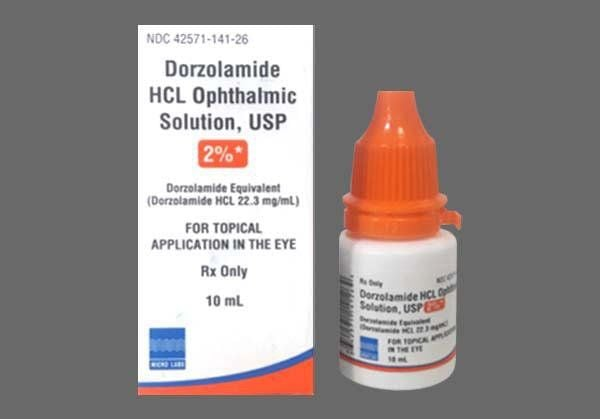

üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 98.jpg
üìÑ K·∫øt qu·∫£ OCR:
D4 - (efu (zo1( RAMAIAH PATIENT DATE Memorial Hospltal PRESCRIPTION suf4edzu CgW4-262 Namre Shaileka_kamal Hosp. No: PKQQ22)LOl_ Age Sex R Inj PeMbESIVir 6u filowed bx (et 4 (Day 2 ~Jays) Guu (3310 9 reactions contact your doctor immediately Ph : 2360 e888 Note: In case of any adverse Mh0ob 560 054 Vunkramalat-Indt org Msram h eon Msrt2960 808310088 F080 22183270 Suatnaniacem (0080 2880 314- Dy Looms Aayy iN (oOmg
üîç T√™n thu·ªëc nh·∫≠n di·ªán: ['RAM']
‚úÖ **Th√¥ng tin thu·ªëc ƒë∆∞·ª£c tr√≠ch xu·∫•t:**
üîπ **T√™n:** nan
üíä **M√¥ t·∫£:** nan
üîó **M√£ DrugBank:** DB008
üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: 97.jpg
üìÑ K·∫øt qu·∫£ OCR:
RIVERSIDE MEDICAL CENTRE 824 [4" Street New York; NY 91743. USA NAME JeLa Sotl AGE 34 ADDRESS 162 St_ML DATE 02-1IZ Betaloc IOO~a +45 Bid Dorzolamizvm I0 ~3 +45 BD Cimetigine 50 ~3 2 +45, TiD Oxprelol +45 Dc.Steve_JoLason signature DLABEL REFILL 0(D2 3 4 5 PRN Exanpl 50~3
üîç T

In [14]:
from IPython.display import display  # ƒê·∫£m b·∫£o ƒë√£ import display t·ª´ IPython

# 8. V√≤ng l·∫∑p x·ª≠ l√Ω h√†ng lo·∫°t ·∫£nh ƒë∆°n thu·ªëc
# --------------------------------------------------------
for filename in os.listdir(prescription_images_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(prescription_images_folder, filename)
        print(f"üöÄ ƒêang x·ª≠ l√Ω ·∫£nh ƒë∆°n thu·ªëc: {filename}")

        # B∆∞·ªõc 1: OCR s·ª≠ d·ª•ng h√†m ocr_image
        text = ocr_image(image_path)
        print(f"üìÑ K·∫øt qu·∫£ OCR:\n{text}")

        # B∆∞·ªõc 2: Tr√≠ch xu·∫•t t√™n thu·ªëc b·∫±ng m√¥ h√¨nh NER
        extracted_drugs = extract_drug_names(text)
        print(f"üîç T√™n thu·ªëc nh·∫≠n di·ªán: {extracted_drugs}")

        # B∆∞·ªõc 3: T√¨m ki·∫øm th√¥ng tin thu·ªëc trong DrugBank (Vector Search)
        matched_drugs = []
        for drug in extracted_drugs:
            drug_info = search_drug_info(drug, drugbank_df, index, drug_embeddings)
            if drug_info is not None:
                matched_drugs.append(drug_info)

        # B∆∞·ªõc 4: Hi·ªÉn th·ªã k·∫øt qu·∫£
        if matched_drugs:
            print("‚úÖ **Th√¥ng tin thu·ªëc ƒë∆∞·ª£c tr√≠ch xu·∫•t:**")
            for drug in matched_drugs:
                print(f"üîπ **T√™n:** {drug['drug_name']}")
                print(f"üíä **M√¥ t·∫£:** {drug['description']}")
                print(f"üîó **M√£ DrugBank:** {drug['drug_id']}")

                # Hi·ªÉn th·ªã ·∫£nh thu·ªëc n·∫øu c√≥ c·ªôt 'drug_image_path'
                if 'drug_image_path' in drug and pd.notna(drug['drug_image_path']):
                    # Lo·∫°i b·ªè k√Ω t·ª± "/" th·ª´a ·ªü ƒë·∫ßu n·∫øu c√≥
                    drug_img_relative = drug['drug_image_path'].lstrip("/")
                    drug_img_path = os.path.join(drug_images_folder, drug_img_relative)
                    if os.path.exists(drug_img_path):
                        try:
                            # M·ªü ·∫£nh b·∫±ng Pillow (PIL)
                            drug_img = Image.open(drug_img_path)
                            print(f"üñºÔ∏è  ·∫¢nh thu·ªëc: {drug_img_path}")
                            display(drug_img)
                        except Exception as e:
                            print(f"üö® L·ªói khi m·ªü ·∫£nh: {e}")
                    else:
                        print(f"üö® Kh√¥ng t√¨m th·∫•y ·∫£nh cho thu·ªëc: {drug['drug_name']}")
        else:
            print("‚ùå Kh√¥ng t√¨m th·∫•y thu·ªëc n√†o kh·ªõp.")

print("Ho√†n t·∫•t x·ª≠ l√Ω t·∫•t c·∫£ ·∫£nh ƒë∆°n thu·ªëc!")


# M·ª•c m·ªõi